#1. Setup


In [ ]:
import numpy as np
import pandas as pd


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

from torchsummary import summary

import matplotlib.pyplot as plt
import cv2

import time
import os

from PIL import Image

from tqdm import tqdm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from skimage.transform import rescale, resize, downscale_local_mean
from skimage.io import imread, imsave
from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage


torch.manual_seed(1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#2. Data Setup

In [ ]:
cd /content/drive/MyDrive/data/

/content/drive/MyDrive/Wavelets Project/data


In [ ]:
!unzip '/content/drive/My Drive/data/Wavelet_packet_test_db2.zip' -d '/root/datasets'

Archive:  /content/drive/My Drive/data/Wavelet_packet_test_db2.zip
replace /root/datasets/Wavelet_packet_test_db2/Chihuahua/n02085620_2921.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /root/datasets/Wavelet_packet_test_db2/Chihuahua/n02085620_2921.png  
  inflating: /root/datasets/Wavelet_packet_test_db2/Chihuahua/flipped_n02085620_1916.png  
  inflating: /root/datasets/Wavelet_packet_test_db2/Chihuahua/n02085620_275.png  
  inflating: /root/datasets/Wavelet_packet_test_db2/Chihuahua/flipped_n02085620_1558.png  
  inflating: /root/datasets/Wavelet_packet_test_db2/Chihuahua/flipped_n02085620_1271.png  
  inflating: /root/datasets/Wavelet_packet_test_db2/Chihuahua/flipped_n02085620_2614.png  
  inflating: /root/datasets/Wavelet_packet_test_db2/Chihuahua/n02085620_326.png  
  inflating: /root/datasets/Wavelet_packet_test_db2/Chihuahua/n02085620_3033.png  
  inflating: /root/datasets/Wavelet_packet_test_db2/Chihuahua/n02085620_1235.png  
  inflating: /root/datasets/Wavelet_pac

In [ ]:
# define training and test data directories
main_dir = '/root/datasets/Wavelet_packet_test_db2'
split_data_dir = '/root/split_dataset'

classes = ['Beagle', 'Chihuahua', 'French Bulldog', 'German Shepherd', 'Golden Retriever', 'Labrador Retriever', 'Poodle', 'Samoyed', 'Schnauzer', 'Shiba Inu', 'West Highland White Terrier']

In [ ]:
import splitfolders

splitfolders.ratio(main_dir, output=split_data_dir, seed=1337, ratio=(.6, 0.2 , 0.2))


train_dir = os.path.join(split_data_dir, 'train')
val_dir = os.path.join(split_data_dir, 'val')
test_dir = os.path.join(split_data_dir, 'test')

Copying files: 3132 files [00:01, 2160.42 files/s]


In [ ]:
# print(os.path.exists(split_data_dir + '/test/.ipynb_checkpoints'))
# os.rmdir(split_data_dir + '/test/.ipynb_checkpoints')
# print(os.listdir(split_data_dir + '/test'))

# print(os.path.exists(split_data_dir + '/train/.ipynb_checkpoints'))
# os.rmdir(split_data_dir + '/train/.ipynb_checkpoints')
# print(os.listdir(split_data_dir + '/train'))

# print(os.path.exists(split_data_dir + '/val/.ipynb_checkpoints'))
# os.rmdir(split_data_dir + '/val/.ipynb_checkpoints')
# print(os.listdir(split_data_dir + '/val'))


In [ ]:
# load and transform data using ImageFolder

# resize all images to 256 x 256, crop to 224 x 224, transform to tensor, normalize
data_transform = transforms.Compose([transforms.Resize(256)                    
                                     ,transforms.CenterCrop(224)                #[3]
                                     ,transforms.ToTensor()                     #[4]
                                     ,transforms.Normalize(                      #[5]
                                     mean=[0.485, 0.456, 0.406],                #[6]
                                     std=[0.229, 0.224, 0.225]                  #[7]
                                     )
                                    ])
                                   
train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Number of training images: ', len(train_data))
print('Number of validation images: ', len(val_data))
print('Number of test images: ', len(test_data))

Number of training images:  1876
Number of validation images:  624
Number of test images:  632


In [ ]:
# define dataloader parameters
batch_size = 32
num_workers = 0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

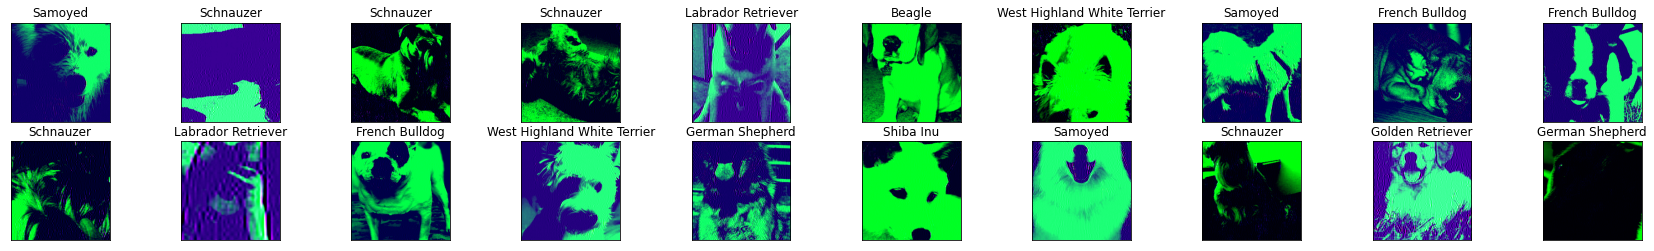

In [ ]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)# dataiter.next()
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(30, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

#3. Transfer Learning

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
features = alexnet.features

#4. Classification Model

In [ ]:
 class AlexClassifier(nn.Module):
    def __init__(self):
        super(AlexClassifier, self).__init__()
        self.fc1 = nn.Linear(256 * 6 * 6,  4069)
        self.fc2 = nn.Linear(4069,  1000)
        self.fc3 = nn.Linear(1000, 11)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#5. Training Setup

In [ ]:
def evaluate(model, loader, criterion):

    total_loss = 0
    total_correct = 0
    total_epoch = 0
    i = 0

    for imgs, labels in iter(loader):
          
        i += 1     

        if use_cuda and torch.cuda.is_available():

          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(features(imgs))
        pred = output.max(1, keepdim=True)[1]
        loss = criterion(output, labels)
        
        total_correct += pred.eq(labels.view_as(pred)).sum().item()
        total_loss += loss.item()
        total_epoch += len(labels)

    err =  1 - (total_correct/ total_epoch)
    loss = total_loss / (i + 1)
    return err, loss

In [ ]:
def get_accuracy(model, loader):
    correct = 0
    total = 0
    
    for imgs, labels in loader:
        
        if use_cuda and torch.cuda.is_available():
          
          imgs = imgs.cuda()
          labels = labels.cuda()
        
        output = model(features(imgs))
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit 

        correct += pred.eq(labels.view_as(pred)).sum().item()
        # print('correct: ', correct)
        total += imgs.shape[0]
        # print('incorrect: ', total - correct)
    return correct / total

In [ ]:
def train(model, train_loader, val_loader, batch_size=20, learning_rate = 0.001,  num_epochs=1):


  torch.manual_seed(1000)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  iters, train_error, val_error, train_loss, val_loss = [], [], [], [], []

  # training

  n = 0 # the number of iterations

  start_time = time.time()

  for epoch in range(num_epochs):

      mini_b= 0
      mini_batch_correct = 0
      Mini_batch_total = 0
      
      for imgs, labels in iter(train_loader):       
          
      #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():

          imgs = imgs.cuda()
          labels = labels.cuda()
        
        out = model(features(imgs))             # forward pass
        loss = criterion(out, labels) # compute the total loss

        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()         # a clean up step for PyTorch

        pred = out.max(1, keepdim=True)[1]
        mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
        Mini_batch_total = imgs.shape[0]

        train_error.append(1 - (mini_batch_correct / Mini_batch_total))
        train_loss.append(loss.item())
        

        iters.append(n)
        val_err, val_los = evaluate(model, val_loader, criterion)
        val_error.append(val_err)  # compute validation accuracy
        val_loss.append(val_los)  # compute validation accuracy

        n += 1
        mini_b += 1

      print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))


  end_time = time.time()
  # plotting
  fig, (ax1, ax2) = plt.subplots(1, 2)

  ax1.set_title("Error")
  ax1.plot(iters, train_error, label="Training")
  ax1.plot(iters, val_error, label="Validation") 
  ax1.set_xlabel("Iterations")
  ax1.set_ylabel("Error")
  ax1.legend(loc='best')

  ax2.set_title("Loss")
  ax2.plot(iters, train_loss, label="Training")
  ax2.plot(iters, val_loss, label="Validation")    
  ax2.set_xlabel("Iterations")
  ax2.set_ylabel("Loss")
  ax2.legend(loc='best')
  
  fig.show()


  train_error.append(1 - get_accuracy(model, train_loader))

  print("Final Training Error:   {}\tFinal Training Accuracy:   {}".format(train_error[-1],1 - train_error[-1]))
  print("Final Validation Error: {}\tFinal Validation Accuracy: {}".format(val_error[-1]  ,1 - val_error[-1]  ))
  print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( (end_time-start_time), ((end_time-start_time) / num_epochs) ))

#6. Test Setup

In [ ]:
def get_test_accuracy(model, data):
    correct = 0
    total = 0

    loader = torch.utils.data.DataLoader(data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

    # model.eval() #*********#
    
    for imgs, labels in loader:
        
        if use_cuda and torch.cuda.is_available():
          
          imgs = imgs.cuda()
          labels = labels.cuda()
        
        output = model(imgs)
        
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        
        image = images[0]
        # place the colour channel at the end, instead of at the beginning
        img = np.transpose(image, [1,2,0])
        # normalize pixel intensity values to [0, 1]
        img = img / 2 + 0.5
        plt.subplot(3, 5, 1)
        plt.axis('off')
        plt.imshow(img)
        
        correct += pred.eq(labels.view_as(pred)).sum().item()
        print("predict", output)
        total += imgs.shape[0]
    return correct / total

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

def get_random_images(data_dir, num):

    data_transform = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor()
                                        #  ,transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                                         ])

    data = datasets.ImageFolder(data_dir, transform=data_transform)
    classes = data.classes
    # classes.remove('.ipynb_checkpoints')

    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)

    return loader

#7. Training

CUDA is available!  Training on GPU ...
Epoch 0 Finished.  Time per Epoch:  125.39 s 
Epoch 1 Finished.  Time per Epoch:  121.32 s 
Epoch 2 Finished.  Time per Epoch:  119.97 s 
Epoch 3 Finished.  Time per Epoch:  118.41 s 
Epoch 4 Finished.  Time per Epoch:  117.64 s 
Epoch 5 Finished.  Time per Epoch:  117.27 s 
Epoch 6 Finished.  Time per Epoch:  116.92 s 
Epoch 7 Finished.  Time per Epoch:  116.65 s 
Epoch 8 Finished.  Time per Epoch:  116.38 s 
Epoch 9 Finished.  Time per Epoch:  116.08 s 
Final Training Error:   0.0	Final Training Accuracy:   1.0
Final Validation Error: 0.1923076923076923	Final Validation Accuracy: 0.8076923076923077
Total time:   1160.83 s  Time per Epoch:  116.08 s 


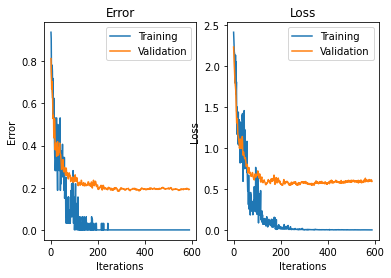

In [ ]:
use_cuda = True
features = alexnet.features
alex = AlexClassifier()

if use_cuda and torch.cuda.is_available():
  alex.cuda()
  features.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(alex, train_loader, val_loader, batch_size=32, num_epochs=10, learning_rate=0.0001)

#8. Test

In [ ]:
test_accuracy  = get_accuracy(alex, test_loader)

print('The test Accuracy is:',test_accuracy )

The test Accuracy is: 0.8164556962025317


In [ ]:
loader = get_random_images(test_dir, 10)
dataiter = iter(loader)
images, labels = dataiter.next()

if use_cuda and torch.cuda.is_available():

    images = images.cuda()
    labels = labels.cuda()

outputs = alex(features(images))

AttributeError: ignored

In [ ]:
fig=plt.figure(figsize=(120,100))
accuracy = 0
for i in list(range(0, 10)):
    pred  = loader.dataset.classes[outputs[i].max(-1, keepdim=True)[1]]
    img =  images[i].cpu()
    lbl = loader.dataset.classes[labels[i]]

    if pred == lbl:
        accuracy += 1

    ax = fig.add_subplot(5, 50/2, i+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(img, (1, 2, 0)))
    title = 'True Label: ' + lbl + '\n Prediction Label: ' + pred
    ax.set_title(title)
    
plt.show()
print('Accuracy: ', accuracy)